In [344]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import math
import pdb
from scipy.stats import poisson

# Load Data

In [345]:
base_path = "/Users/loreliegordon/Library/Mobile Documents/com~apple~CloudDocs/Documents/root/Columbia/Fall2021/ELEN4720/Assignments/assignment2/"

X_all = pd.read_csv(base_path + "hw2-data/Bayes_classifier/X.csv", header=None)
y_all = pd.read_csv(base_path + "hw2-data/Bayes_classifier/y.csv", header=None)

X_all = X_all.copy().to_numpy()
y_all = y_all.copy().to_numpy()

y_train = y_all
X_train = X_all

In [346]:
y_train = y_all
X_train = X_all


# X_train[:,0].reshape(4600, 1).shape, y_train.shape


# What the Naive Bayes Classifier does

## Training
- Calculate the probability of y0 or y1 without considering x
- Calculate λy,d for each input colum X


## Predicting
To Predict we use the prior probability distribution p(y0 = y|π) and multiply

In [347]:
class NaiveBayesClassifier():
    """NaiveBayesClassifier

    This is an implementation from scratch that has the following:
    - Input data x is assumed to follow a poisson distribution with prior gamma(2,1)
    - Y follows a bernoulli
    """

    def __init__(self) -> None:
        pass

    def fit(self, X_train, y_train):
        """Fit the input data

        After this function the model parameters will be fit. We need to have:
        - pi hat which is the probability of encountering class 0 or class 1 without considering X
        - λ is λy,d that was calculated for each input colum X

        Args:
            X_train (np.array): Training features
            y_train (np.array): Single column for the binary predicted class either 0 or 1
        """
        self.d = len(X_train[0])
        self.n = len(y_train)
        self._n_y0 = len(y_train[y_train == 0])
        self._n_y1 = len(y_train[y_train == 1])
        self.p_y0 = self._n_y0 / self.n
        self.p_y1 = self._n_y1 / self.n

        def inner_product(x_in, y_in):
            x_in = x_in.reshape(len(x_in), 1)
            return y_in.T @ x_in

        # These are vectors for each input dimension on X_train
        self._x_times_y = np.apply_along_axis(inner_product, 0, X_train, y_in=y_train).reshape(1, self.d)
        self._x_times_one_minus_y = np.apply_along_axis(inner_product, 0, X_train, y_in=(1-y_train)).reshape(1, self.d)
        self.lambda_hat_y0 = (1 + self._x_times_one_minus_y)/(1 + self._n_y0)
        self.lambda_hat_y1 =  (1 + self._x_times_y)/(1 + self._n_y1)
        self.lambda_hat_y0 = self.lambda_hat_y0.reshape(self.d)
        self.lambda_hat_y1 = self.lambda_hat_y1.reshape(self.d)

    def predict(self, X):
        """Predict new data

        To predict we need to:
            - Calculate the probability of being either class
            - Choose the class with the higher probability
        """
        # Apply the following function across each column of X, then multiply them
            # p(x0,d|λy,d),   = (λ^(xi)*e^(-λ))/(xi!)   where λ is λy,d that was calculated for each input colum X
      
        p_x0_d_given_labmda_d_y0 = np.zeros(shape=(len(X), self.d))
        p_x0_d_given_labmda_d_y1 = np.zeros(shape=(len(X), self.d))

        for i in range(len(X[0])):
            lambda_d = self.lambda_hat_y0[i]
            x_d = X[:,i]
            x_d = x_d.reshape(len(X), 1)
            ret = poisson.pmf(x_d, lambda_d).reshape(len(X))
            p_x0_d_given_labmda_d_y0[:, i] = ret

        for i in range(len(X[0])):
            lambda_d = self.lambda_hat_y1[i]
            x_d = X[:, i]
            x_d = x_d.reshape(len(X), 1)
            ret = poisson.pmf(x_d, lambda_d).reshape(len(X))
            p_x0_d_given_labmda_d_y1[:, i] = ret

        y_pred_y0 = np.multiply.reduce(p_x0_d_given_labmda_d_y0, axis=1)
        y_pred_y1 = np.multiply.reduce(p_x0_d_given_labmda_d_y1, axis=1)
        y_pred_y0 = self.p_y0 * y_pred_y0
        y_pred_y1 = self.p_y1 * y_pred_y1
        return (y_pred_y1 > y_pred_y0).astype(int)

In [348]:

y_test_1_y_pred_1 = []
y_test_0_y_pred_0 = []
y_test_1_y_pred_0 = []
y_test_0_y_pred_1 = []

poisson_vals_0 = []
poisson_vals_1 = []

kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X_all):
    X_train, X_test = X_all[train_index], X_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]

    cl = NaiveBayesClassifier()

    cl.fit(X_train, y_train)
    y_pred = cl.predict(X_test)

    poisson_vals_0.append(cl.lambda_hat_y0)
    poisson_vals_1.append(cl.lambda_hat_y1)

    joined = pd.concat([pd.DataFrame(y_pred, columns=["y_pred"]), pd.DataFrame(y_test, columns=["y_test"])], axis=1)
    joined["correct"] = joined["y_pred"] == joined["y_test"]
    y_test_1_y_pred_1.append(joined.loc[(joined["correct"] == True) & (joined["y_test"] == 1),"correct"].count()) # /len(y_test)
    y_test_0_y_pred_0.append(joined.loc[(joined["correct"] == True) & (joined["y_test"] == 0),"correct"].count()) # /len(y_test)
    y_test_1_y_pred_0.append(joined.loc[(joined["correct"] == False) & (joined["y_test"] == 1),"correct"].count()) # /len(y_test)
    y_test_0_y_pred_1.append(joined.loc[(joined["correct"] == False) & (joined["y_test"] == 0),"correct"].count()) # /len(y_test)
    
y_test_0_y_pred_0_avg = sum(y_test_0_y_pred_0)#/len(y_test_0_y_pred_0)
y_test_0_y_pred_1_avg = sum(y_test_0_y_pred_1)#/len(y_test_0_y_pred_1)
y_test_1_y_pred_0_avg = sum(y_test_1_y_pred_0)#/len(y_test_1_y_pred_0)
y_test_1_y_pred_1_avg = sum(y_test_1_y_pred_1)#/len(y_test_1_y_pred_1)
[[y_test_0_y_pred_0_avg, y_test_0_y_pred_1_avg], [y_test_1_y_pred_0_avg, y_test_1_y_pred_1_avg]]
acc = (y_test_0_y_pred_0_avg + y_test_1_y_pred_1_avg) / sum([y_test_0_y_pred_0_avg, y_test_0_y_pred_1_avg, y_test_1_y_pred_0_avg, y_test_1_y_pred_1_avg])
print(f"Accuracy is {acc}")

[[2297, 490], [109, 1704]]

Accuracy is 0.8697826086956522


In [350]:
spam_cols=["make","address","all","3d","our","over","remove","internet","order","mail","receive","will","people","report","addresses","free","business","email","you","credit","your","font","000","money","hp","hpl","george","650","lab","labs","telnet","857","data","415","85","technology","1999","parts","pm","direct","cs","meeting","original","project","re","edu","table","conference",";","(","[","!","$","#"]
spam_cols = [f"{i+1}_{x}" for i, x in enumerate(spam_cols)]
poisson_vals_0_avg = pd.DataFrame(poisson_vals_0, columns=spam_cols).mean()
poisson_vals_0_avg = pd.DataFrame(poisson_vals_0_avg, columns=["vals"])
poisson_vals_0_avg["word"] = poisson_vals_0_avg.index
poisson_vals_1_avg = pd.DataFrame(poisson_vals_1, columns=spam_cols).mean()
poisson_vals_1_avg = pd.DataFrame(poisson_vals_1_avg, columns=["vals"])
poisson_vals_1_avg["word"] = poisson_vals_1_avg.index

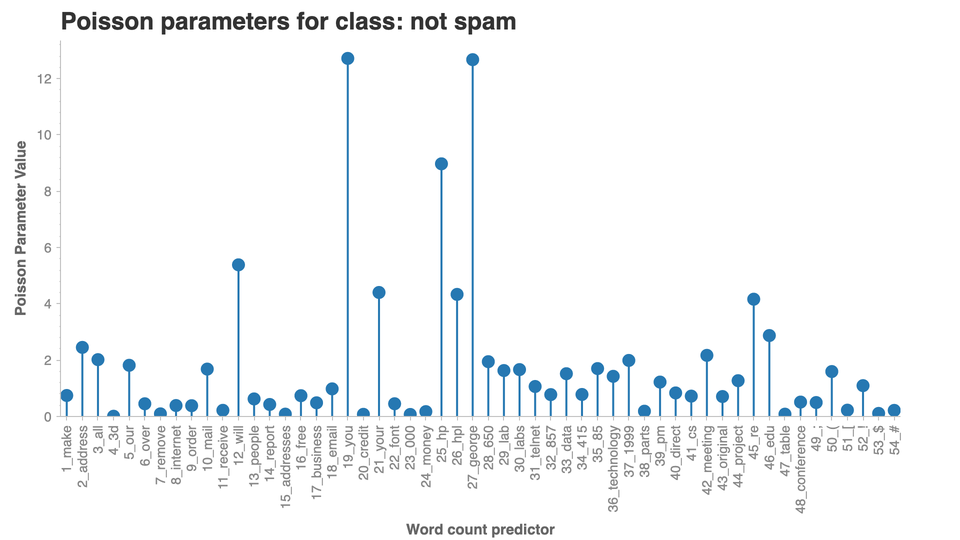

In [351]:
import chartify
ch = chartify.Chart(blank_labels=True, x_axis_type="categorical")
ch.set_title("Poisson parameters for class: not spam")
ch.plot.lollipop(
    data_frame=poisson_vals_0_avg,
    categorical_columns=["word"],
    numeric_column='vals',
    categorical_order_by=poisson_vals_0_avg["word"].tolist())
ch.axes.set_yaxis_label("Poisson Parameter Value")
ch.axes.set_xaxis_label("Word count predictor")
ch.axes.set_xaxis_tick_orientation("vertical")
ch.show('png')

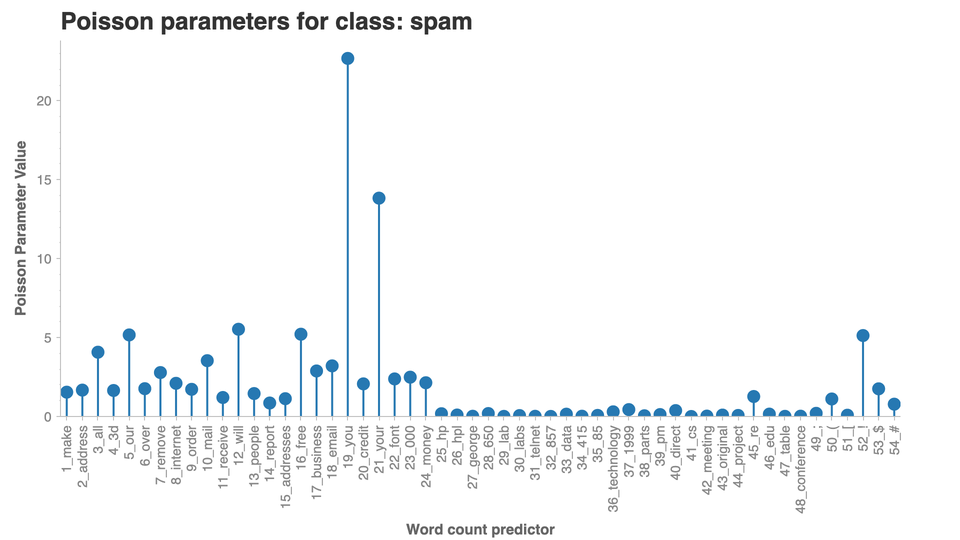

In [352]:
import chartify
ch = chartify.Chart(blank_labels=True, x_axis_type="categorical")
ch.set_title("Poisson parameters for class: spam")
ch.plot.lollipop(
    data_frame=poisson_vals_1_avg,
    categorical_columns=["word"],
    numeric_column='vals',
    categorical_order_by=poisson_vals_1_avg["word"].tolist())
ch.axes.set_yaxis_label("Poisson Parameter Value")
ch.axes.set_xaxis_label("Word count predictor")
ch.axes.set_xaxis_tick_orientation("vertical")
ch.show('png')